In [45]:
# Importing libraries

import pandas as pd
import numpy as np
import time
from pandas import json_normalize
import json
from datetime import datetime

from bs4 import BeautifulSoup
import requests
from scrapethat import *
import cloudscraper
from urllib.request import urlopen

import plotly.express as px
import plotly.io as pio
import plotly.figure_factory as ff
from plotnine import *
import plotly.graph_objects as go

# EARTHQUAKES IN 2023
## AN ANALYSIS OF ALL EARTHQUAKE ABOVE 5.5 MAGNITUDE IN 2023 (from USGS data)

#### IMPORTING THE DATA

In [46]:
### from USGS Site

url = "https://earthquake.usgs.gov/earthquakes/map/?extent=-85.93257,26.01563&extent=85.88239,333.98438&range=search&listOnlyShown=true&baseLayer=terrain&timeZone=utc&search=%7B%22name%22:%22Search%20Results%22,%22params%22:%7B%22starttime%22:%221900-01-01%2000:00:00%22,%22minmagnitude%22:7,%22orderby%22:%22time%22%7D%7D"

In [47]:
# Setting the parameters for the data request
start_time = 'now-354days' # to get all 2023 to date
min_magnitude = 5.5
latitude = -90
longitude = -180
max_radius_km = 20000

In [48]:
url = requests.get(f'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime={start_time}&minmagnitude={min_magnitude}&latitude={latitude}&longitude={longitude}&maxradiuskm={max_radius_km}')
dataset = url.json()

In [49]:
data = dataset['features']
data

[{'type': 'Feature',
  'properties': {'mag': 6.2,
   'place': '11 km SSE of Iray, Peru',
   'time': 1703074280991,
   'updated': 1703119005489,
   'tz': None,
   'url': 'https://earthquake.usgs.gov/earthquakes/eventpage/us7000lkb1',
   'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us7000lkb1&format=geojson',
   'felt': 31,
   'cdi': 5.6,
   'mmi': 5.228,
   'alert': 'green',
   'status': 'reviewed',
   'tsunami': 0,
   'sig': 609,
   'net': 'us',
   'code': '7000lkb1',
   'ids': ',us7000lkb1,usauto7000lkb1,at00s5ysiw,pt23354000,',
   'sources': ',us,usauto,at,pt,',
   'types': ',dyfi,ground-failure,internal-moment-tensor,internal-origin,losspager,moment-tensor,origin,phase-data,shakemap,',
   'nst': 94,
   'dmin': 3.228,
   'rms': 1.27,
   'gap': 67,
   'magType': 'mww',
   'type': 'earthquake',
   'title': 'M 6.2 - 11 km SSE of Iray, Peru'},
  'geometry': {'type': 'Point', 'coordinates': [-72.6028, -15.9595, 93.43]},
  'id': 'us7000lkb1'},
 {'type': 'Feature',
  

In [50]:
# Checking the number of keys in the first dictionary (there are to levels with secondry keys and values)
num_keys = len(data[0].keys())

# Getting the number of rows
num_rows = len(data)

print(f"Number of keys: {num_keys}")
print(f"Number of rows: {num_rows}")

Number of keys: 4
Number of rows: 504


#### We adjusted the magnitude both to focus on major earthquakes and to have an adequate dataset size, in this case 504.


#### CLEANING THE DATASET

In [51]:
# Dropping unnecessary keys

selected_keys = ['properties', 'geometry']
filtered_data = [
    {key: item[key] for key in selected_keys if key in item}
    for item in data]

In [52]:
# Creating function to simplify the dataset and have a single layer of keys

def flat_dict(d, parent_key=''):
    """
    Get only 1 level of data and merge the key labels between primary and secondary when needed
    """
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}_{k}" if parent_key else k  # merging primary and secondary key names for secondary keys
        if isinstance(v, dict):
            items.extend(flat_dict(v, new_key).items())
        else:
            items.append((new_key, v))
    return dict(items)

# Flattening dictionaries

new_data = [flat_dict(item) for item in filtered_data]

In [53]:
# Dropping again unnecessary keys to keep only the ones necessary to the analysis

selected_keys = ['properties_mag', 'properties_place', 'properties_time', 'properties_alert', 'geometry_coordinates']
reduced_data = [{key: item[key] for key in selected_keys if key in item} for item in new_data]
data = pd.DataFrame(reduced_data)

In [54]:
# Splitting "properties_place" in two: "main region" and "location indication"

def split_column(row):
    if pd.isna(row['properties_place']): # checking against null
        return pd.Series(['', ''], index = ['location indication', 'main region'])
    elif ',' in row['properties_place']:
        values = row['properties_place'].split(', ', 1)  # Split at first occurrence
        return pd.Series(values, index = ['location indication', 'main region']) 
    else:  
        return pd.Series(['', row['properties_place']], index = ['location indication', 'main region'])
    
# Applying the function to each row
data[['location indication', 'main region']] = data.apply(split_column, axis=1)

# Dropping the original column
data = data.drop("properties_place", axis=1)
data

,properties_mag,properties_time,properties_alert,geometry_coordinates,location indication,main region
0,6.2,1703074280991,green,"[-72.6028, -15.9595, 93.43]",11 km SSE of Iray,Peru
1,5.6,1703074154409,green,"[-27.7844, -56.1136, 116.596]",,South Sandwich Islands region
2,5.9,1702915170100,red,"[102.8272, 35.7432, 10]",37 km WNW of Linxia Chengguanzhen,China
3,5.7,1702798679246,green,"[169.1683, -21.5747, 10]",133 km E of Tadine,New Caledonia
4,5.7,1702720253149,green,"[145.6893, 20.2629, 10]",Maug Islands region,Northern Mariana Islands
...,...,...,...,...,...,...
499,5.5,1672769965631,green,"[-29.2475, 0.8467, 10]",,central Mid-Atlantic Ridge
500,5.6,1672757613655,green,"[178.8954, -65.4071, 10]",,Balleny Islands region
501,5.5,1672751348163,green,"[179.2943, -65.1631, 10]",,Balleny Islands region
502,5.8,1672597602628,green,"[-123.5343, -56.2415, 10]",,southern East Pacific Rise


In [55]:
# Converting 'properties_time' column to datetime format

data['properties_time'] = pd.to_datetime(data['properties_time'], unit = 'ms')  # USGS data in milliseconds

# Splitting datetime to get date column

data['date'] = data['properties_time'].dt.date

# Dropping old column
data = data.drop("properties_time", axis = 1)

In [56]:
# Renaming 

data.rename(columns={"properties_mag": "magnitude", "properties_alert": "alert_level", "geometry_coordinates": "geo_coordinates"}, inplace = True)

In [57]:
# Checking against null values in the geo_coordinates

null_values = data['geo_coordinates'].isnull().sum()
if null_values > 0:
    print(f'There are {null_values} null values in the coordinates.')
else:
    print('There are no null values in the coordinates.')

There are no null values in the coordinates.


In [58]:
#Dropping the last value (i.e.'elevation') from the geo_coordinates column

data['geo_coordinates'] = data['geo_coordinates'].apply(lambda x: x[:-1] if x else x)

In [59]:
# Extracting the longitude and latitude

data['longitude'] = data['geo_coordinates'].apply(lambda x: x[0])
data['latitude'] = data['geo_coordinates'].apply(lambda x: x[1])

# Final data set
data

,magnitude,alert_level,geo_coordinates,location indication,main region,date,longitude,latitude
0,6.2,green,"[-72.6028, -15.9595]",11 km SSE of Iray,Peru,2023-12-20,-72.6028,-15.9595
1,5.6,green,"[-27.7844, -56.1136]",,South Sandwich Islands region,2023-12-20,-27.7844,-56.1136
2,5.9,red,"[102.8272, 35.7432]",37 km WNW of Linxia Chengguanzhen,China,2023-12-18,102.8272,35.7432
3,5.7,green,"[169.1683, -21.5747]",133 km E of Tadine,New Caledonia,2023-12-17,169.1683,-21.5747
4,5.7,green,"[145.6893, 20.2629]",Maug Islands region,Northern Mariana Islands,2023-12-16,145.6893,20.2629
...,...,...,...,...,...,...,...,...
499,5.5,green,"[-29.2475, 0.8467]",,central Mid-Atlantic Ridge,2023-01-03,-29.2475,0.8467
500,5.6,green,"[178.8954, -65.4071]",,Balleny Islands region,2023-01-03,178.8954,-65.4071
501,5.5,green,"[179.2943, -65.1631]",,Balleny Islands region,2023-01-03,179.2943,-65.1631
502,5.8,green,"[-123.5343, -56.2415]",,southern East Pacific Rise,2023-01-01,-123.5343,-56.2415


### GRAPHICAL ANALYSIS OF THE DATASET

In [60]:
pio.templates.default = 'plotly_white'

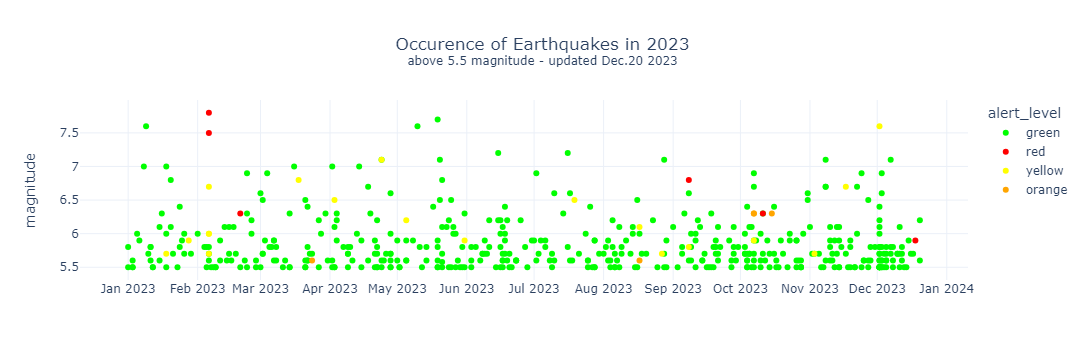

In [61]:
# Analysis of 5.5+ earthquake frequency

colors = {"green":"lime", "yellow":"yellow","orange":"orange","red":"red"}
graph = px.scatter(data,
                   x = 'date',
                   y = 'magnitude',
                   title = 'Occurence of Earthquakes in 2023<br><sup>above 5.5 magnitude - updated Dec.20 2023</sup>',
                   color = 'alert_level',
                   color_discrete_map = colors
                   )
graph.update_layout(title_x = 0.5)
graph.update_xaxes(title = '')
graph.update_xaxes(title='', dtick='M1')
graph.show()

#### The over 500 earthquake seem to be spread equally over time. Six earthquakes were cassified red alert. The 2 deadly-famous earthquakes in Turkey show on February 6th.
______________________________________________________________________________________________________________________________________________

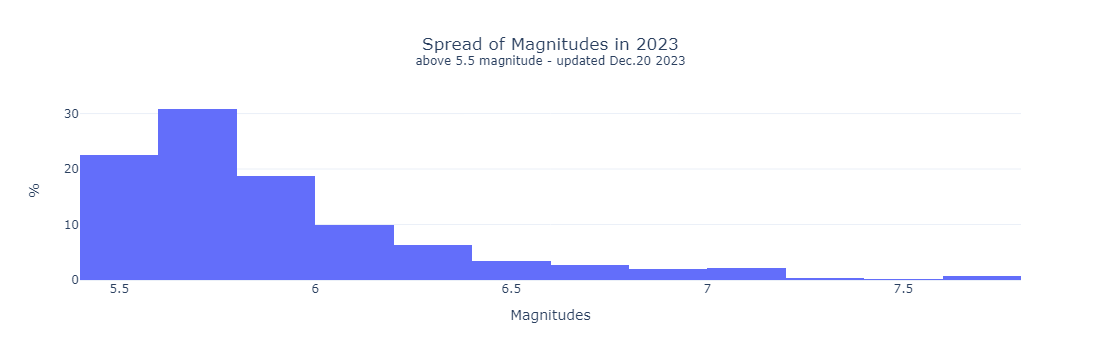

In [62]:
# Analysis of earthquake spread

histo = px.histogram(data,
                     x = 'magnitude',
                     histnorm = 'percent',
                     nbins = 20,
                     title = 'Spread of Magnitudes in 2023<br><sup>above 5.5 magnitude - updated Dec.20 2023</sup>')
histo.update_layout(title_x = 0.5)
histo.update_xaxes(title = 'Magnitudes')
histo.update_yaxes(title = '%')
histo.show()

#### Just above 30% of these 5.5+ earthquakes are between 5.6 and 5.7, to then decrease progressively as the magnitude raises. 
__________________________________________________________________________________________________________________________________

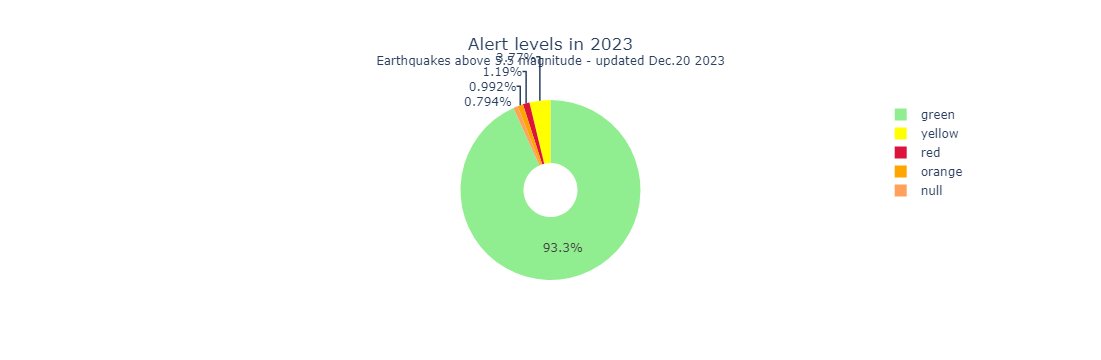

In [84]:
# Analysis of earthquake spread by alert level

color_map = {'green': 'lightgreen', 'yellow': 'yellow', 'orange': 'orange', 'red': 'crimson'}
pie = px.pie(data, names = 'alert_level', title = 'Alert levels in 2023<br><sup>Earthquakes above 5.5 magnitude - updated Dec.20 2023</sup>',
             labels = {'alert_level': 'Alert Levels'},
             hole = 0.3,
             color = 'alert_level',
             color_discrete_map = color_map)
pie.update_layout(title_x = 0.5)
pie.update_xaxes(title='')
pie.update_yaxes(title='%')
pie.show()

#### Thankfully the large majority of 5.5+ earthquakes have a green alert level, the lowest of all.
_________________________________________________________________________________________________________________________

In [85]:
# Creating a dynamic map of all 5.5+ earthquake of 2023 (to date)

fig = go.Figure()

fig.add_trace(go.Scattermapbox(
    lat = data['latitude'],
    lon = data['longitude'],
    mode = 'markers',
    marker = go.scattermapbox.Marker(
        size = (data['magnitude']-5)*7, 
        color = data['magnitude'],
        colorbar = dict(title = 'Magnitude')
    ),
    text = data.apply(lambda row: f"Region:{row['main region']}, Magnitude: {row['magnitude']}, Date: {row['date']}", axis = 1),
    showlegend = True
))
fig.update_layout(
    title = "Georgraphical View of Earthquakes in 2023<br><sup>above 5.5 magnitude - updated Dec.20 2023</sup>",
    mapbox = dict(
        style = "carto-darkmatter",
        center = dict(lon = data['longitude'].mean(), lat = data['latitude'].mean()),
        zoom = 1),
    title_x = 0.5,
    height =600,
    width = 1000
)
fig.show()


#### Scrolling on this dynamic map will illustrate the intense activity in the friction zones of the continental plates. Please note that both size and color are relating to magnitude to better show the biggest events.
_____________________________________________________________________________________________________________________________________________

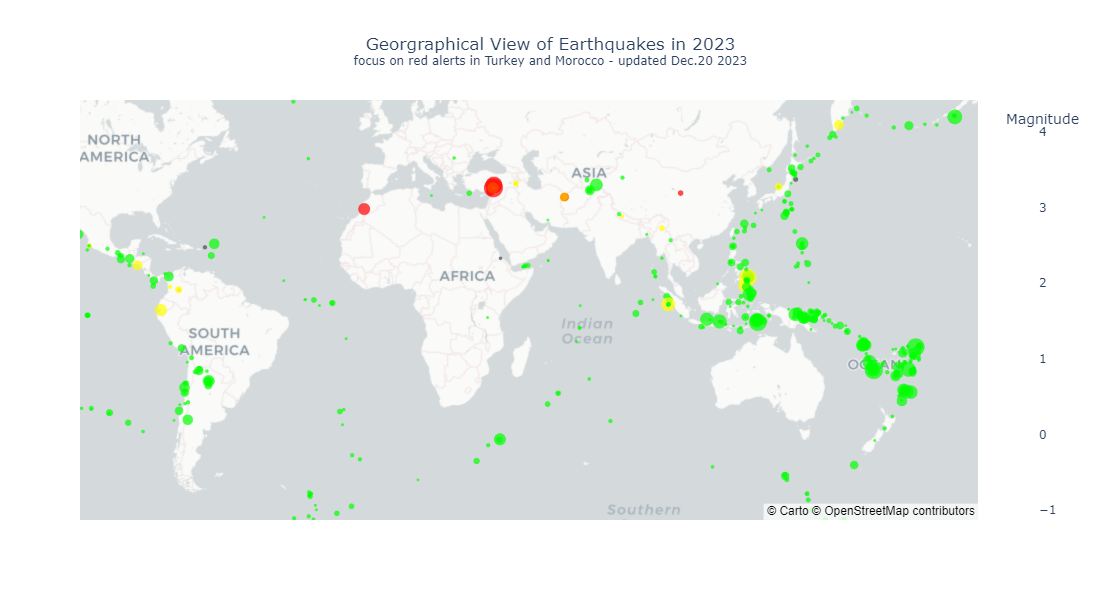

In [70]:
# Creating a dynamic map of all 5.5+ earthquake of 2023 (to date)

fig = go.Figure()
color_scale = {"green":"lime", "yellow":"yellow","orange":"orange","red":"red"}
fig.add_trace(go.Scattermapbox(
    lat = data['latitude'],
    lon = data['longitude'],
    mode = 'markers',
    marker = go.scattermapbox.Marker(
        size = (data['magnitude']-5)*7, 
        color = data['alert_level'].map(color_scale),
        colorbar = dict(title = 'Magnitude')
    ),
    text = data.apply(lambda row: f"Region:{row['main region']}, Magnitude: {row['magnitude']}, Date: {row['date']}", axis = 1),
    showlegend = False
))
fig.update_layout(
    title = "Georgraphical View of Earthquakes in 2023<br><sup>focus on red alerts in Turkey and Morocco - updated Dec.20 2023</sup>",
        mapbox = dict(
        style = "carto-positron",
        center = dict(lon = data['longitude'].mean(), lat = data['latitude'].mean()),
        zoom = 1),
    title_x = 0.5,
    height =600,
    width = 1000
)
fig.show()
